<a href="https://colab.research.google.com/github/Kyounghyeon/Python-DeepLearning-Pytorch/blob/main/Chap03_AutoEncoder(FashionMNIST).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

이 챕터에서는 Fashion MNIST 데이터를 이용해 오토인코더를 실습합니다.

# AutoEncoder(AE)


In [121]:
from IPython.display import Image

In [122]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [123]:
cd /content/drive/MyDrive/colab

/content/drive/MyDrive/colab


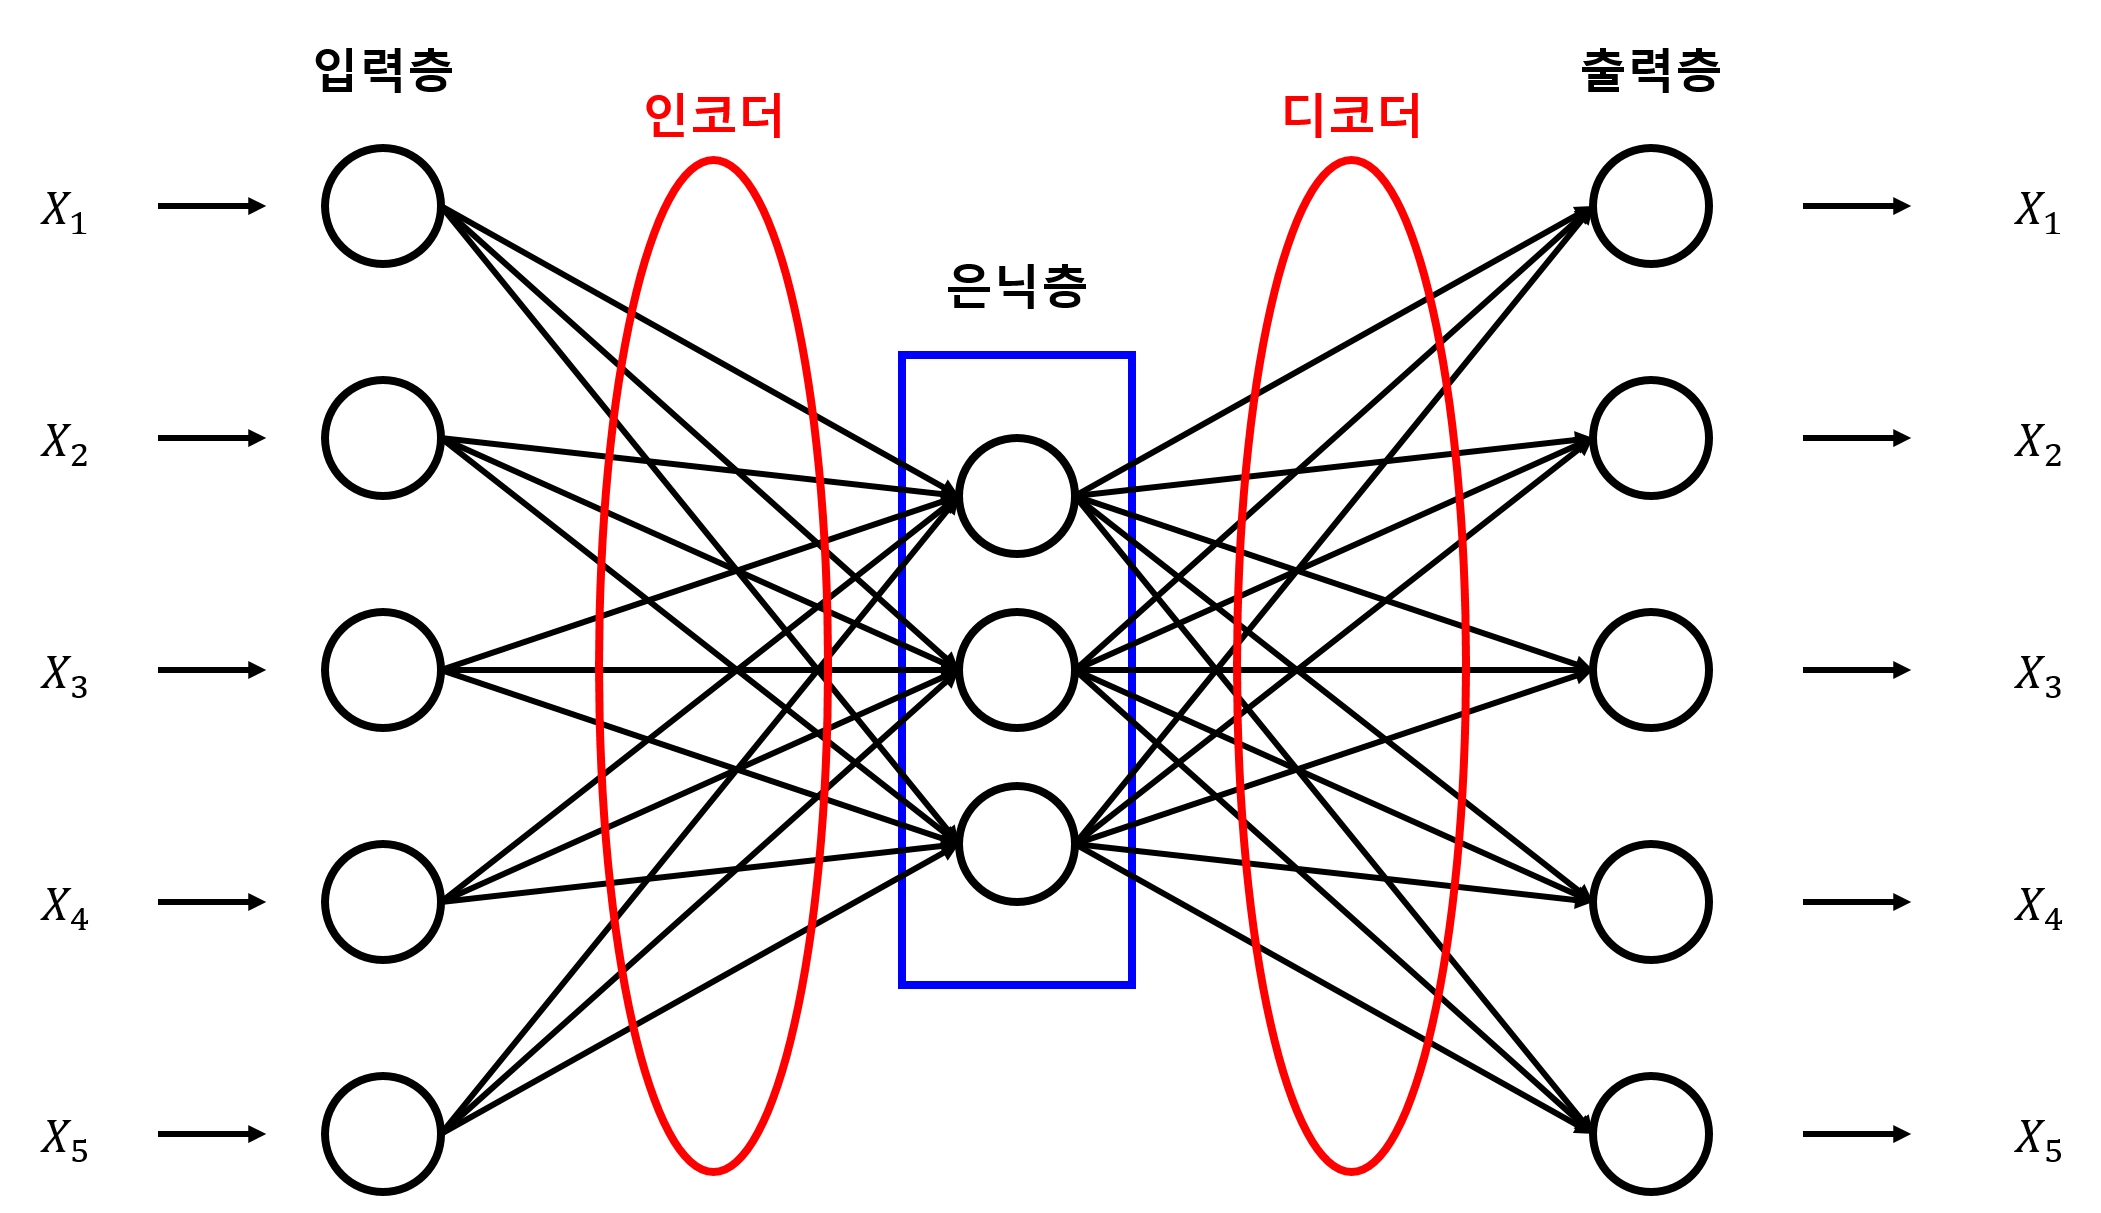

In [124]:
Image("img/AutoEncoder.jpg", width=500, height=250)

- AutoEncoder(AE)  
오토인코더는 대표적인 비지도학습 신경망 모델로 input과 output을 똑같이 설정한다. hidden layer의 앞부분을 Encoder, 뒷부분을 Decoder라고 부른다. AE를 활용하면 input값을 latent space에 압축시켜 새로운 feature로 활용할 수 있다. 자기 자신을 input과 output에 동시에 사용하는 모델인만큼 자기 자신을 잘 복원할 수 있는 모델이라면 이 새로운 feature는 의미가 있을 것임.

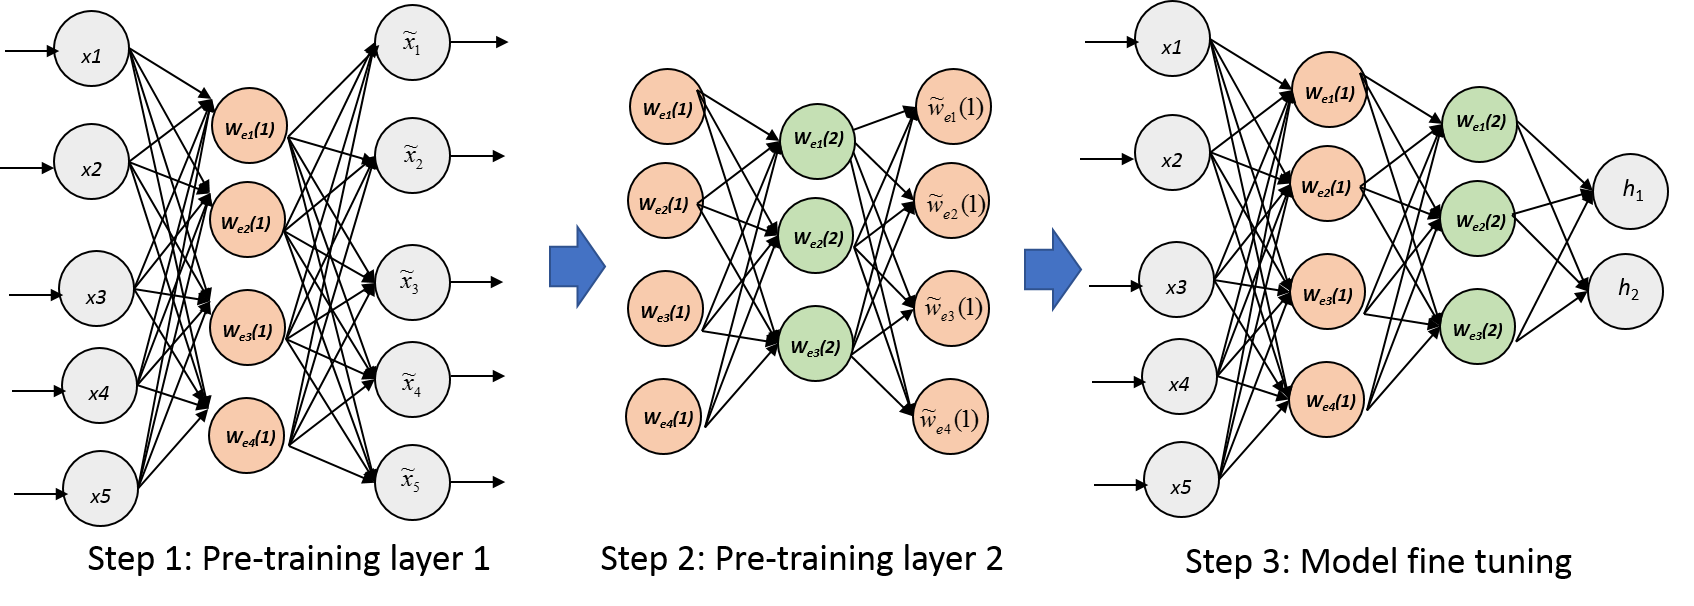

In [ ]:
Image("img/Stacked AE.png", width=700, height=400)

- Stacked AE  
AE를 여러개 쌓은 모델로 각각 하나의 AE를 hidden layer로 하여 원하는 만큼 사용자가 지정하여 AE를 기존 MLP 모델의 hidden layer처럼 쌓아올린 모델이다. 각각의 AE를 학습시켜 hidden layer를 연결하고, 이후에 전체 AE가 연결된 모델을 한번더 학습시키는 것이 Stacked AE의 과정이다.  
여기서 *Pre-Trained Model*과 *Fine-tuning*개념을 찾아볼 수 있다. 전자는 각각의 AE를 학습시킨후 hidden layer로 사용하는 것처럼 데이터를 미리 학습시키는 것을 의미하며, 후자는 미리 학습된 데이터를 모아 한번더 학습시키는 것을 의미한다.

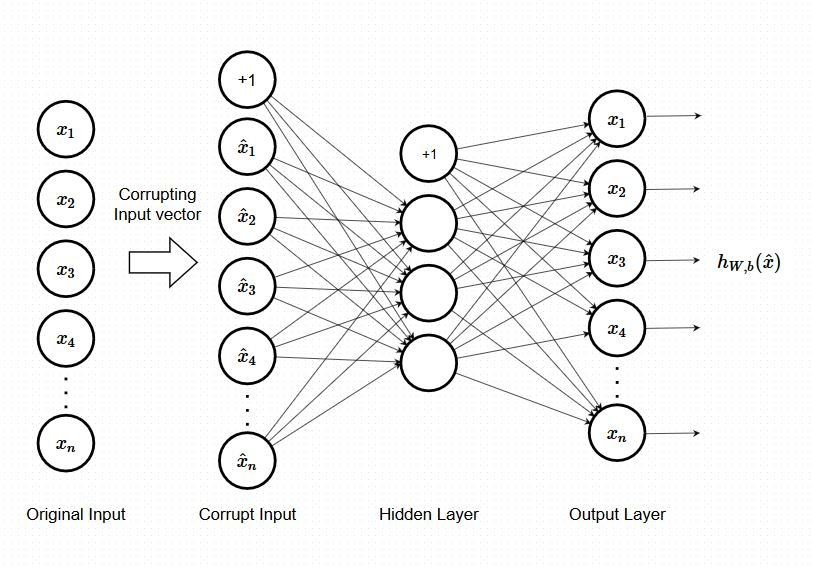

In [ ]:
Image("img/Denoising AE.png", width=500, height=250)

- Denoising AE  
original input 데이터에 noise(corruption)을 추가하여 모델을 학습시킴. 더욱더 Robust한 feature를 만들기 위함.

# 오토인코더 실습 Fashin MNIST

In [125]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets

In [126]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [127]:
torch.__version__

'1.9.0+cu102'

In [128]:
device

device(type='cuda')

In [132]:
# 미니배치 사용하기 위해 배치 사이즈 조절
BATCH_SIZE = 32
EPOCHS = 10

## 데이터 다운로드

In [131]:
train_dataset = datasets.FashionMNIST(root = "../data/FashionMNIST",
                                      train = True,
                                      download = True,
                                      transform = transforms.ToTensor())
test_dataset = datasets.FashionMNIST(root = "../data/FashionMNIST",
                                      train = False,
                                      download = True,
                                      transform = transforms.ToTensor())

# 미니배치 단위만큼 데이터 묶기
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = False)

In [133]:
for (X_train, y_train) in train_loader:
    print('X_train: ', X_train.size(), 'type: ', X_train.type())
    print('y_train: ', y_train.size(), 'type: ', y_train.type())
    break

X_train:  torch.Size([32, 1, 28, 28]) type:  torch.FloatTensor
y_train:  torch.Size([32]) type:  torch.LongTensor


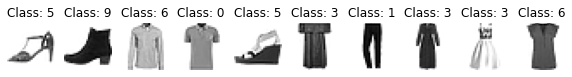

In [134]:
pltsize = 1
plt.figure(figsize = (10 * pltsize, pltsize))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis("off")
    plt.imshow(X_train[i, :, :, :].numpy().reshape(28,28), cmap = "gray_r")
    plt.title("Class: "+str(y_train[i].item()))

## AutoEncoder 모델 설계

In [135]:
class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 32),
        )

        self.decoder = nn.Sequential(
            nn.Linear(32,256),
            nn.ReLU(),
            nn.Linear(256,512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


## Optimizer, Loss function 설정

In [136]:
model = AE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = .001)
criterion = nn.MSELoss()

print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
    (4): Linear(in_features=256, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=784, bias=True)
  )
)


## AE모델에 대해 train 데이터를 학습 시키는 함수 정의

In [138]:
def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (image, _) in enumerate(train_loader): 
        image = image.view(-1, 28 * 28).to(device)
        true_image = image.view(-1, 28 * 28).to(device)
        optimizer.zero_grad()
        encoded, decoded = model(image)
        loss = criterion(decoded, true_image)
        loss.backward()
        optimizer.step()

        if batch_idx % log_interval == 0:
            print(f"Train Epoch : {epoch} [{batch_idx * len(image)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)] \t Train Loss : {loss.item():.5f}")

## 학습된 AE 모델에 대해 test 데이터로 검증하는 함수 정의

In [139]:
def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    real_img = []
    gen_img = []

    with torch.no_grad():
        for image, _ in test_loader:
            image = image.view(-1, 28*28).to(device)
            true_image = image.view(-1, 28*28).to(device)
            encoded, decoded = model(image)

            test_loss += criterion(decoded, true_image).item()
            real_img.append(image.to("cpu"))
            gen_img.append(decoded.to("cpu"))

    test_loss /= len(test_loader.dataset)
    return test_loss, real_img, gen_img

Train Epoch : 1 [0/60000 (0%)] 	 Train Loss : 0.22721
Train Epoch : 1 [6400/60000 (11%)] 	 Train Loss : 0.02721
Train Epoch : 1 [12800/60000 (21%)] 	 Train Loss : 0.02348
Train Epoch : 1 [19200/60000 (32%)] 	 Train Loss : 0.02002
Train Epoch : 1 [25600/60000 (43%)] 	 Train Loss : 0.01912
Train Epoch : 1 [32000/60000 (53%)] 	 Train Loss : 0.02146
Train Epoch : 1 [38400/60000 (64%)] 	 Train Loss : 0.01849
Train Epoch : 1 [44800/60000 (75%)] 	 Train Loss : 0.01480
Train Epoch : 1 [51200/60000 (85%)] 	 Train Loss : 0.01564
Train Epoch : 1 [57600/60000 (96%)] 	 Train Loss : 0.01820
[EPOCH] : 1 		 Test Loss : 0.00049


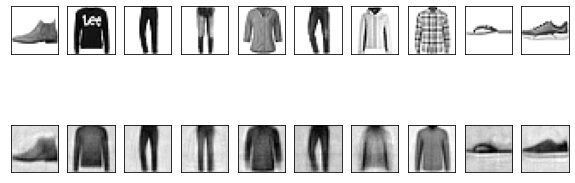

Train Epoch : 2 [0/60000 (0%)] 	 Train Loss : 0.01429
Train Epoch : 2 [6400/60000 (11%)] 	 Train Loss : 0.01620
Train Epoch : 2 [12800/60000 (21%)] 	 Train Loss : 0.01513
Train Epoch : 2 [19200/60000 (32%)] 	 Train Loss : 0.01169
Train Epoch : 2 [25600/60000 (43%)] 	 Train Loss : 0.01585
Train Epoch : 2 [32000/60000 (53%)] 	 Train Loss : 0.01040
Train Epoch : 2 [38400/60000 (64%)] 	 Train Loss : 0.01328
Train Epoch : 2 [44800/60000 (75%)] 	 Train Loss : 0.01137
Train Epoch : 2 [51200/60000 (85%)] 	 Train Loss : 0.01533
Train Epoch : 2 [57600/60000 (96%)] 	 Train Loss : 0.01032
[EPOCH] : 1 		 Test Loss : 0.00041


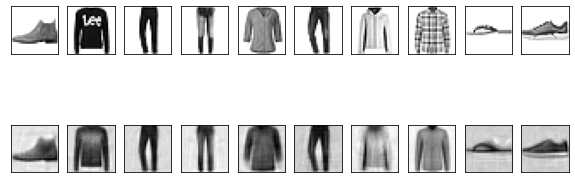

Train Epoch : 3 [0/60000 (0%)] 	 Train Loss : 0.01025
Train Epoch : 3 [6400/60000 (11%)] 	 Train Loss : 0.01601
Train Epoch : 3 [12800/60000 (21%)] 	 Train Loss : 0.01200
Train Epoch : 3 [19200/60000 (32%)] 	 Train Loss : 0.01314
Train Epoch : 3 [25600/60000 (43%)] 	 Train Loss : 0.01475
Train Epoch : 3 [32000/60000 (53%)] 	 Train Loss : 0.01462
Train Epoch : 3 [38400/60000 (64%)] 	 Train Loss : 0.01058
Train Epoch : 3 [44800/60000 (75%)] 	 Train Loss : 0.01389
Train Epoch : 3 [51200/60000 (85%)] 	 Train Loss : 0.01201
Train Epoch : 3 [57600/60000 (96%)] 	 Train Loss : 0.01190
[EPOCH] : 1 		 Test Loss : 0.00038


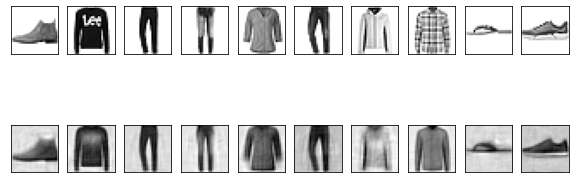

Train Epoch : 4 [0/60000 (0%)] 	 Train Loss : 0.01046
Train Epoch : 4 [6400/60000 (11%)] 	 Train Loss : 0.01162
Train Epoch : 4 [12800/60000 (21%)] 	 Train Loss : 0.00992
Train Epoch : 4 [19200/60000 (32%)] 	 Train Loss : 0.01240
Train Epoch : 4 [25600/60000 (43%)] 	 Train Loss : 0.01125
Train Epoch : 4 [32000/60000 (53%)] 	 Train Loss : 0.00858
Train Epoch : 4 [38400/60000 (64%)] 	 Train Loss : 0.00909
Train Epoch : 4 [44800/60000 (75%)] 	 Train Loss : 0.01219
Train Epoch : 4 [51200/60000 (85%)] 	 Train Loss : 0.01203
Train Epoch : 4 [57600/60000 (96%)] 	 Train Loss : 0.01277
[EPOCH] : 1 		 Test Loss : 0.00035


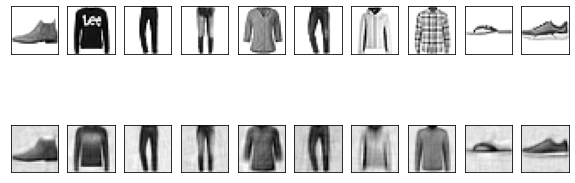

Train Epoch : 5 [0/60000 (0%)] 	 Train Loss : 0.01306
Train Epoch : 5 [6400/60000 (11%)] 	 Train Loss : 0.01132
Train Epoch : 5 [12800/60000 (21%)] 	 Train Loss : 0.01264
Train Epoch : 5 [19200/60000 (32%)] 	 Train Loss : 0.01050
Train Epoch : 5 [25600/60000 (43%)] 	 Train Loss : 0.01430
Train Epoch : 5 [32000/60000 (53%)] 	 Train Loss : 0.01207
Train Epoch : 5 [38400/60000 (64%)] 	 Train Loss : 0.01198
Train Epoch : 5 [44800/60000 (75%)] 	 Train Loss : 0.00892
Train Epoch : 5 [51200/60000 (85%)] 	 Train Loss : 0.00916
Train Epoch : 5 [57600/60000 (96%)] 	 Train Loss : 0.01376
[EPOCH] : 1 		 Test Loss : 0.00033


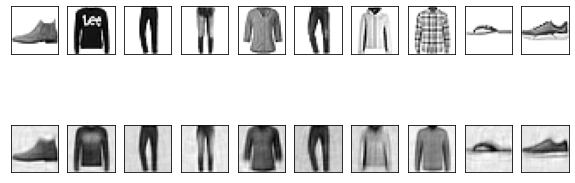

Train Epoch : 6 [0/60000 (0%)] 	 Train Loss : 0.00948
Train Epoch : 6 [6400/60000 (11%)] 	 Train Loss : 0.00856
Train Epoch : 6 [12800/60000 (21%)] 	 Train Loss : 0.01055
Train Epoch : 6 [19200/60000 (32%)] 	 Train Loss : 0.01108
Train Epoch : 6 [25600/60000 (43%)] 	 Train Loss : 0.01086
Train Epoch : 6 [32000/60000 (53%)] 	 Train Loss : 0.01084
Train Epoch : 6 [38400/60000 (64%)] 	 Train Loss : 0.00735
Train Epoch : 6 [44800/60000 (75%)] 	 Train Loss : 0.01130
Train Epoch : 6 [51200/60000 (85%)] 	 Train Loss : 0.01107
Train Epoch : 6 [57600/60000 (96%)] 	 Train Loss : 0.00920
[EPOCH] : 1 		 Test Loss : 0.00033


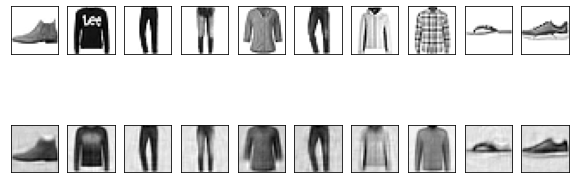

Train Epoch : 7 [0/60000 (0%)] 	 Train Loss : 0.00983
Train Epoch : 7 [6400/60000 (11%)] 	 Train Loss : 0.00874
Train Epoch : 7 [12800/60000 (21%)] 	 Train Loss : 0.00728
Train Epoch : 7 [19200/60000 (32%)] 	 Train Loss : 0.00916
Train Epoch : 7 [25600/60000 (43%)] 	 Train Loss : 0.01309
Train Epoch : 7 [32000/60000 (53%)] 	 Train Loss : 0.00916
Train Epoch : 7 [38400/60000 (64%)] 	 Train Loss : 0.00857
Train Epoch : 7 [44800/60000 (75%)] 	 Train Loss : 0.00951
Train Epoch : 7 [51200/60000 (85%)] 	 Train Loss : 0.01218
Train Epoch : 7 [57600/60000 (96%)] 	 Train Loss : 0.01488
[EPOCH] : 1 		 Test Loss : 0.00032


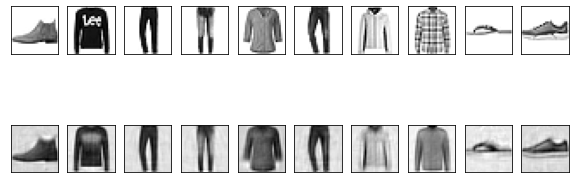

Train Epoch : 8 [0/60000 (0%)] 	 Train Loss : 0.01329
Train Epoch : 8 [6400/60000 (11%)] 	 Train Loss : 0.00753
Train Epoch : 8 [12800/60000 (21%)] 	 Train Loss : 0.00933
Train Epoch : 8 [19200/60000 (32%)] 	 Train Loss : 0.01129
Train Epoch : 8 [25600/60000 (43%)] 	 Train Loss : 0.00929
Train Epoch : 8 [32000/60000 (53%)] 	 Train Loss : 0.00901
Train Epoch : 8 [38400/60000 (64%)] 	 Train Loss : 0.01010
Train Epoch : 8 [44800/60000 (75%)] 	 Train Loss : 0.01332
Train Epoch : 8 [51200/60000 (85%)] 	 Train Loss : 0.01310
Train Epoch : 8 [57600/60000 (96%)] 	 Train Loss : 0.00982
[EPOCH] : 1 		 Test Loss : 0.00031


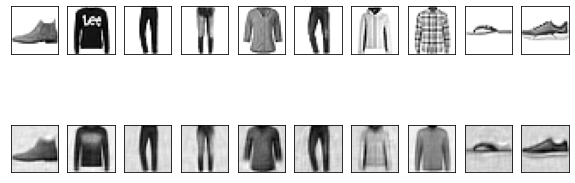

Train Epoch : 9 [0/60000 (0%)] 	 Train Loss : 0.01123
Train Epoch : 9 [6400/60000 (11%)] 	 Train Loss : 0.00906
Train Epoch : 9 [12800/60000 (21%)] 	 Train Loss : 0.01073
Train Epoch : 9 [19200/60000 (32%)] 	 Train Loss : 0.00825
Train Epoch : 9 [25600/60000 (43%)] 	 Train Loss : 0.01081
Train Epoch : 9 [32000/60000 (53%)] 	 Train Loss : 0.00871
Train Epoch : 9 [38400/60000 (64%)] 	 Train Loss : 0.01031
Train Epoch : 9 [44800/60000 (75%)] 	 Train Loss : 0.00880
Train Epoch : 9 [51200/60000 (85%)] 	 Train Loss : 0.00889
Train Epoch : 9 [57600/60000 (96%)] 	 Train Loss : 0.00969
[EPOCH] : 1 		 Test Loss : 0.00031


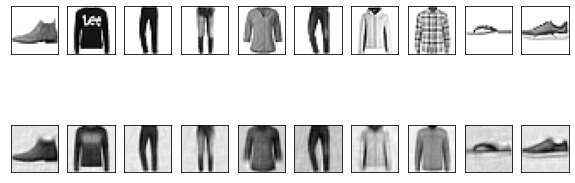

Train Epoch : 10 [0/60000 (0%)] 	 Train Loss : 0.00878
Train Epoch : 10 [6400/60000 (11%)] 	 Train Loss : 0.01097
Train Epoch : 10 [12800/60000 (21%)] 	 Train Loss : 0.00847
Train Epoch : 10 [19200/60000 (32%)] 	 Train Loss : 0.01224
Train Epoch : 10 [25600/60000 (43%)] 	 Train Loss : 0.00989
Train Epoch : 10 [32000/60000 (53%)] 	 Train Loss : 0.00838
Train Epoch : 10 [38400/60000 (64%)] 	 Train Loss : 0.01028
Train Epoch : 10 [44800/60000 (75%)] 	 Train Loss : 0.00940
Train Epoch : 10 [51200/60000 (85%)] 	 Train Loss : 0.00836
Train Epoch : 10 [57600/60000 (96%)] 	 Train Loss : 0.01045
[EPOCH] : 1 		 Test Loss : 0.00031


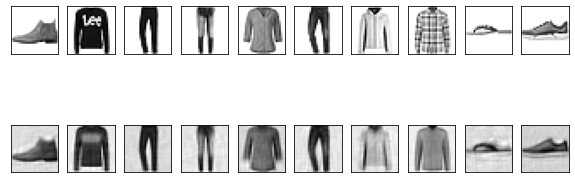

In [140]:

for epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, log_interval = 200)
    test_loss, real_img, gen_img = evaluate(model, test_loader)
    print(f"[EPOCH] : {Epoch} \t\t Test Loss : {test_loss:.5f}")

    f,a = plt.subplots(2, 10, figsize = (10,4))
    for i in range(10):
        img = np.reshape(real_img[0][i], (28,28))
        a[0][i].imshow(img, cmap = "gray_r")
        a[0][i].set_xticks(())
        a[0][i].set_yticks(())

    for i in range(10):
        img = np.reshape(gen_img[0][i], (28,28))
        a[1][i].imshow(img, cmap = "gray_r")
        a[1][i].set_xticks(())
        a[1][i].set_yticks(())

    plt.show()
    print("="*50)